## 1. Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR  
import lightgbm as lgb 
from xgboost import XGBRFRegressor

from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error 

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings
warnings.filterwarnings('ignore')

## 2. Loading saved data

### 2.1 Data before dimensionality reduction

In [2]:
all_data = pd.read_csv('./processed_zhengqi_data2.csv')

# Get training data
cond = all_data['label'] == 'train'
train_data = all_data[cond]
train_data.drop(labels='label', axis=1, inplace=True)
# Splitting data
X_train, X_valid, y_train, y_valid = train_test_split(train_data.drop(labels='target', axis=1), train_data['target'], test_size=0.2)

# Get test data
cond2 = all_data['label'] == 'test'
test_data = all_data[cond2]
test_data.drop(labels=['label','target'], axis=1, inplace=True)

### 2.2 Data after dimensionality reduction

In [3]:
# Data saved after PCA dimensionality reduction
train_data_pca = np.load('./train_data_pca.npz')['X_train']
target_data_pca = np.load('./train_data_pca.npz')['y_train']

# Splitting data
X_train_pca, X_valid_pca, y_train_pca, y_valid_pca = train_test_split(train_data_pca, target_data_pca, test_size=0.2)
test_data_pca = np.load('./test_data_pca.npz')['X_test']

## 3. Create a function to plot the model learning curve

### A learning curve is a graphical tool used to show how the performance of a model changes with the number of training samples or training iterations during training. It is usually used to evaluate the learning effect of a model and help determine whether the model is underfitting or overfitting.

### Learning curves usually contain two curves: training error curve and validation error curve.

### By observing the learning curves, we can better understand the performance of the model:
#### Detecting underfitting: If the training error and validation error are both high and similar, it means that the model is not capturing the patterns in the data well, and you may need to increase the complexity of the model. 
####   Detecting overfitting: If the training error is low and the validation error is high, it means that the model performs well on the training data, but has poor generalization ability on new data, and you may need to regularize or use more data.


<div style="text-align: center;">
    <img src="./pic/sklearn_cross_validation.png" alt="My Image" width="500"/>
</div>

In [4]:
def plot_learning_curve(model,title,X,y,cv=None):
    # Calculating learning curve data
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv)
    
    # Calculate the mean and std of the training and test set scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    
    # Draw the training set score curve
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,color="r")
    
    # Draw the test set score curve
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    # Plot Settings
    plt.grid()  # Show Grid
    plt.legend(loc="best")   # Add legend at optimal location
 
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

## 4. Multiple Linear Regression Learning Curve

### 4.1 Dimensionality reduction data modeling 

In [5]:
clf = LinearRegression()
clf.fit(X_train_pca, y_train_pca)
score = mean_squared_error(y_valid_pca, clf.predict(X_valid_pca))
print("LinearRegression:   ", score)

LinearRegression:    0.11680787672777476


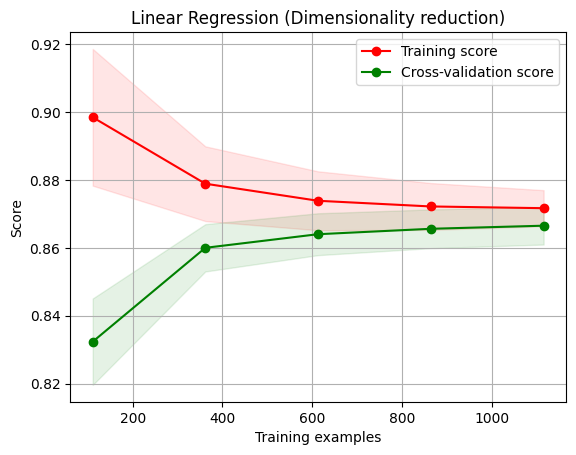

In [6]:
# Score : 0.10912434853473307
X = X_train_pca
y = y_train_pca

title = "Linear Regression (Dimensionality reduction)"
cv = ShuffleSplit(n_splits=100, test_size=0.5)
estimator = LinearRegression()
plot_learning_curve(estimator, title, X, y, cv=cv)
plt.savefig('./results/LinearRegression(DR) Learning Curve.png',dpi = 200)

In [7]:
model = LinearRegression()
model.fit(train_data_pca,target_data_pca)
y_ = model.predict(test_data_pca)
display(y_)
np.savetxt('./results/LinearRegression(DR).txt',y_)

array([ 0.13150668,  0.16945978, -0.27342445, ..., -2.47823434,
       -2.51566308, -2.43677965])

### 4.2 Non dimensionality reduction data modeling

In [8]:
clf = LinearRegression()
clf.fit(X_train, y_train)
score = mean_squared_error(y_valid, clf.predict(X_valid))
print("LinearRegression:   ", score)

LinearRegression:    0.0924595758718884


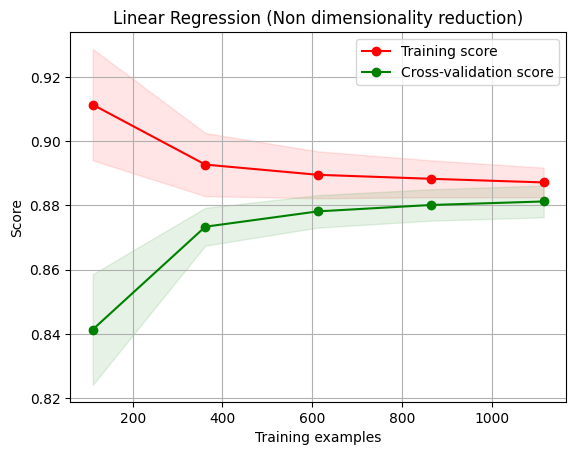

In [9]:
# Score: 0.10641804205051382
X = X_train
y = y_train

title = "Linear Regression (Non dimensionality reduction)"
cv = ShuffleSplit(n_splits=100, test_size=0.5)
estimator = LinearRegression()
plot_learning_curve(estimator, title, X, y, cv=cv)
plt.savefig('./results/LinearRegression(NDR) Learning Curve.png',dpi = 200)

In [10]:
model = LinearRegression()
model.fit(train_data.drop('target',axis = 1),train_data['target'])
y_ = model.predict(test_data)
display(y_)
np.savetxt('./results/LinearRegression(NDR).txt',y_)

array([ 0.17956796,  0.21233229, -0.17473794, ..., -2.45401699,
       -2.45401899, -2.06151025])

## 5. Random Forest Learning Curve

### 5.1 Dimensionality reduction data modeling

In [11]:
model = RandomForestRegressor(
    n_estimators=200,            # 200 Trees Model
    max_depth=10,                # Maximum tree depth
    max_features='sqrt',         # The amount of feature selection when building the tree
    min_samples_leaf=10,         # Minimum number of samples for a leaf node
    min_samples_split=40,        
    criterion='squared_error'   
)

model.fit(X_train_pca, y_train_pca)
score = mean_squared_error(y_valid_pca, model.predict(X_valid_pca))
print("Random Forest: ", score)

Random Forest:  0.2253957865805953


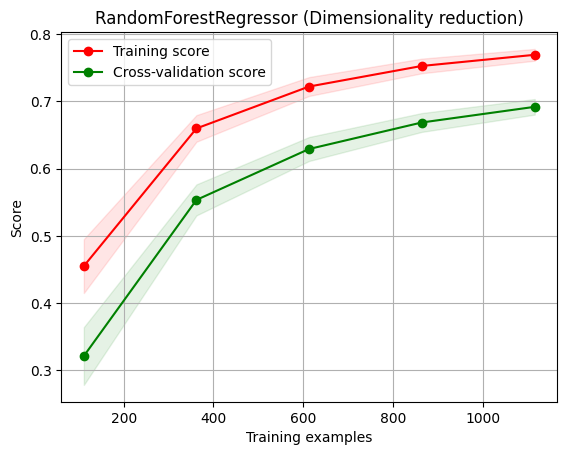

In [12]:
# Score: 0.21375181419630282
X = X_train_pca
y = y_train_pca
title = "RandomForestRegressor (Dimensionality reduction)"

model = RandomForestRegressor(
    n_estimators=200,            # 200 Trees Model
    max_depth=10,                # Maximum tree depth
    max_features='sqrt',         # The amount of feature selection when building the tree
    min_samples_leaf=10,         # Minimum number of samples for a leaf node
    min_samples_split=40,        
    criterion='squared_error'   
)
cv = ShuffleSplit(n_splits=100, test_size=0.5)
plot_learning_curve(model, title, X, y, cv = cv)
plt.savefig('./results/RandomForest(DR) Learning Curve.png',dpi = 200)

In [13]:
model = RandomForestRegressor(
    n_estimators=200,            # 200 Trees Model
    max_depth=10,                # Maximum tree depth
    max_features='sqrt',         # The amount of feature selection when building the tree
    min_samples_leaf=10,         # Minimum number of samples for a leaf node
    min_samples_split=40,        
    criterion='squared_error'   
)
model.fit(train_data_pca,target_data_pca)
y_ = model.predict(test_data_pca)
display(y_)
np.savetxt('./results/RandomForest(DR).txt',y_)

array([ 0.3612834 ,  0.36368813, -0.0797377 , ..., -1.14264848,
       -1.19379732, -1.2314725 ])

### 5.2 Non dimensionality reduction data modeling

In [14]:
model = RandomForestRegressor(
    n_estimators=200,            # 200 Trees Model
    max_depth=10,                # Maximum tree depth
    max_features='sqrt',         # The amount of feature selection when building the tree
    min_samples_leaf=10,         # Minimum number of samples for a leaf node
    min_samples_split=40,        
    criterion='squared_error'   
)

model.fit(X_train, y_train)
score = mean_squared_error(y_valid, model.predict(X_valid))
print("Random Forest: ", score)

Random Forest:  0.10381670715030603


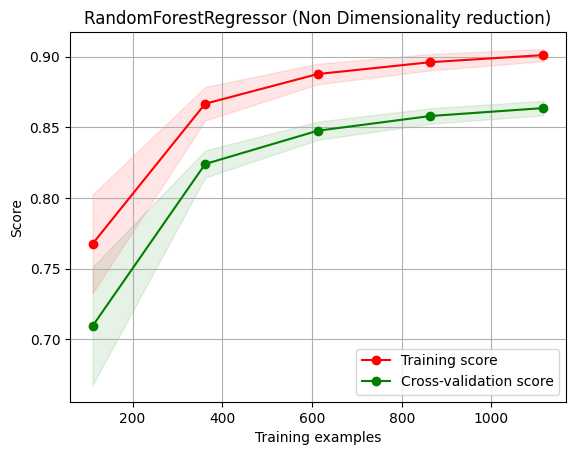

In [15]:
# Score: 0.1161441
X = X_train
y = y_train
title = "RandomForestRegressor (Non Dimensionality reduction)"

model = RandomForestRegressor(
    n_estimators=200,            # 200 Trees Model
    max_depth=10,                # Maximum tree depth
    max_features='sqrt',         # The amount of feature selection when building the tree
    min_samples_leaf=10,         # Minimum number of samples for a leaf node
    min_samples_split=40,        
    criterion='squared_error'   
)
cv = ShuffleSplit(n_splits=100, test_size=0.5)
plot_learning_curve(model, title, X, y, cv = cv)
plt.savefig('./results/RandomForest(NDR) Learning Curve.png',dpi = 200)

In [16]:
model = RandomForestRegressor(
    n_estimators=200,            # 200 Trees Model
    max_depth=10,                # Maximum tree depth
    max_features='sqrt',         # The amount of feature selection when building the tree
    min_samples_leaf=10,         # Minimum number of samples for a leaf node
    min_samples_split=40,        
    criterion='squared_error'   
)
model.fit(train_data.drop('target',axis = 1),train_data['target'])
y_ = model.predict(test_data)
display(y_)
np.savetxt('./results/RandomForest(NDR).txt',y_)

array([ 0.27848393,  0.18188693, -0.11199719, ..., -2.36717706,
       -2.4253161 , -2.40147447])

## 6. Support Vector Machine(SVR)

### 6.1 Dimensionality reduction data modeling

In [17]:
model = SVR(kernel='rbf',C = 1,gamma=0.01,tol = 0.0001,epsilon=0.3)
model.fit(X_train_pca, y_train_pca)
score = mean_squared_error(y_valid_pca, model.predict(X_valid_pca))
print("Support Vector Machine(SVR): ", score)

Support Vector Machine(SVR):  0.10856760211307624


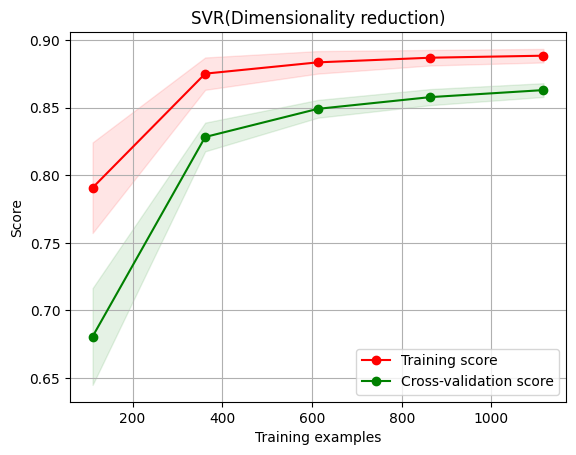

In [18]:
# Score: 0.10928448908508397
X = X_train_pca
y = y_train_pca
title = "SVR(Dimensionality reduction)"
cv = ShuffleSplit(n_splits=100, test_size=0.5)
model = SVR(kernel='rbf',C = 1,gamma=0.01,tol = 0.0001,epsilon=0.3)
plot_learning_curve(model, title, X, y, cv = cv)
plt.savefig('./results/SVR(DR) Learning Curve.png',dpi = 200)

In [19]:
model =  SVR(kernel='rbf',C = 1,gamma=0.01,tol = 0.0001,epsilon=0.3)
model.fit(train_data_pca,target_data_pca)
y_ = model.predict(test_data_pca)
display(y_)
np.savetxt('./results/SVR_rbf(DR).txt',y_)

array([ 0.23848735,  0.19297562, -0.23297472, ..., -2.36283707,
       -2.48796629, -2.67837145])

In [20]:
model =  SVR(kernel='poly')
model.fit(train_data_pca,target_data_pca)
y_ = model.predict(test_data_pca)
display(y_)
np.savetxt('./results/SVR_poly(DR).txt',y_)

array([ 0.22823466,  0.27731328,  0.09155864, ..., -6.02861066,
       -4.89950178, -2.93191958])

### 6.2 Non dimensionality reduction data modeling

In [21]:
model = SVR(kernel='rbf')
model.fit(X_train, y_train)
score = mean_squared_error(y_valid, model.predict(X_valid))
print("Support Vector Machine(SVR): ", score)

Support Vector Machine(SVR):  0.25258346008618116


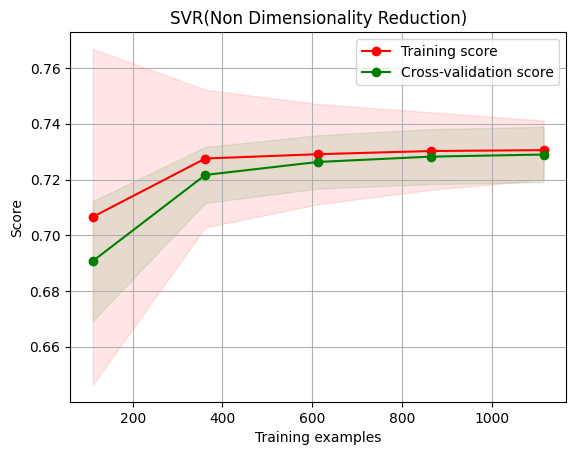

In [22]:
# Score: 0.2504975989368773
X = X_train
y = y_train
title = "SVR(Non Dimensionality Reduction)"
cv = ShuffleSplit(n_splits=100, test_size=0.5)
model = SVR(kernel='rbf')
plot_learning_curve(model, title, X, y, cv = cv)
plt.savefig('./results/SVR(NDR) Learning Curve.png',dpi = 200)

In [23]:
model =SVR(kernel='rbf')
model.fit(train_data.drop('target',axis = 1),train_data['target'])
y_ = model.predict(test_data)
display(y_)
np.savetxt('./results/SVR_rbf(NDR).txt',y_)

array([ 0.02382074,  0.07985432, -0.38231557, ..., -3.27880579,
       -3.2033691 , -3.10675637])

In [24]:
model =SVR(kernel='poly')
model.fit(train_data.drop('target',axis = 1),train_data['target'])
y_ = model.predict(test_data)
display(y_)
np.savetxt('./results/SVR_poly(NDR).txt',y_)

array([-0.07007624, -0.04297824, -0.21375275, ..., -0.45444023,
       -0.45412256, -0.45350324])

## 7. GBDG Gradient Boosting Tree

### 7.1 Dimensionality reduction data modeling

In [25]:
model = GradientBoostingRegressor(learning_rate=0.03, # Learning rate
                                loss='huber',  # Loss function
                                max_depth=14, # Decision Tree Depth
                                max_features='sqrt',# The maximum number of features involved in the judgment when the node splits
                                min_samples_leaf=10,# Minimum number of samples required for a leaf node
                                min_samples_split=40,
                                n_estimators=300,
                                subsample=0.8)
model.fit(X_train_pca, y_train_pca)
score = mean_squared_error(y_valid_pca, model.predict(X_valid_pca))
print("GBDT: ", score)

GBDT:  0.11618379537002702


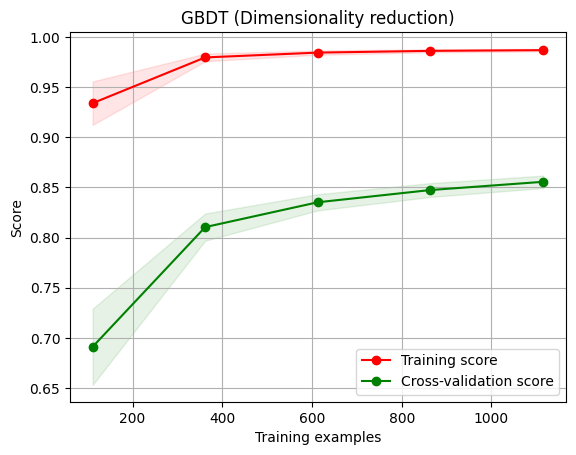

In [26]:
# Score: 0.11842193515758787
X = X_train_pca
y = y_train_pca

title = "GBDT (Dimensionality reduction)"
cv = ShuffleSplit(n_splits=100, test_size=0.5)
model = GradientBoostingRegressor(learning_rate=0.03, # Learning rate
                                loss='huber',  # Loss function
                                max_depth=14, # Decision Tree Depth
                                max_features='sqrt',# The maximum number of features involved in the judgment when the node splits
                                min_samples_leaf=10,# Minimum number of samples required for a leaf node
                                min_samples_split=40,
                                n_estimators=300,
                                subsample=0.8)
plot_learning_curve(model, title, X, y, cv = cv)
plt.savefig('./results/GBDG(DR) Learning Curve.png',dpi = 200)

In [27]:
model = GradientBoostingRegressor(learning_rate=0.03, # Learning rate
                                loss='huber',  # Loss function
                                max_depth=14, # Decision Tree Depth
                                max_features='sqrt',# The maximum number of features involved in the judgment when the node splits
                                min_samples_leaf=10,# Minimum number of samples required for a leaf node
                                min_samples_split=40,
                                n_estimators=300,
                                subsample=0.8)
model.fit(train_data_pca,target_data_pca)
y_ = model.predict(test_data_pca)
display(y_)
np.savetxt('./results/GBDT(DR).txt',y_)

array([ 0.38260769,  0.22133835,  0.02104282, ..., -1.98490431,
       -1.91455844, -2.03121175])

### 7.2 Non dimensionality reduction data modeling

In [28]:
model = GradientBoostingRegressor(learning_rate=0.03, # Learning rate
                                loss='huber',  # Loss function
                                max_depth=14, # Decision Tree Depth
                                max_features='sqrt',# The maximum number of features involved in the judgment when the node splits
                                min_samples_leaf=10,# Minimum number of samples required for a leaf node
                                min_samples_split=40,
                                n_estimators=300,
                                subsample=0.8)
model.fit(X_train, y_train)
score = mean_squared_error(y_valid, model.predict(X_valid))
print("GBDT: ", score)

GBDT:  0.0797026007225149


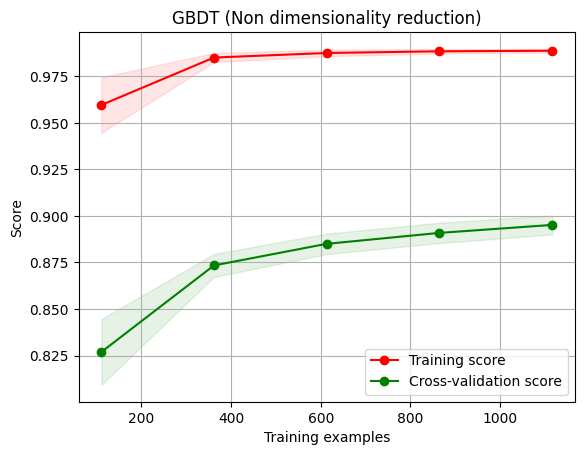

In [29]:
# Score: 0.08868250053960725
X = X_train
y = y_train

title = "GBDT (Non dimensionality reduction)"
cv = ShuffleSplit(n_splits=100, test_size=0.5)
model = GradientBoostingRegressor(learning_rate=0.03, # Learning rate
                                loss='huber',  # Loss function
                                max_depth=14, # Decision Tree Depth
                                max_features='sqrt',# The maximum number of features involved in the judgment when the node splits
                                min_samples_leaf=10,# Minimum number of samples required for a leaf node
                                min_samples_split=40,
                                n_estimators=300,
                                subsample=0.8)
plot_learning_curve(model, title, X, y, cv = cv)
plt.savefig('./results/GBDG(NDR) Learning Curve.png',dpi = 200)

In [30]:
model = GradientBoostingRegressor(learning_rate=0.03, # Learning rate
                                loss='huber',  # Loss function
                                max_depth=14, # Decision Tree Depth
                                max_features='sqrt',# The maximum number of features involved in the judgment when the node splits
                                min_samples_leaf=10,# Minimum number of samples required for a leaf node
                                min_samples_split=40,
                                n_estimators=300,
                                subsample=0.8)
model.fit(train_data.drop('target',axis = 1),train_data['target'])
y_ = model.predict(test_data)
display(y_)
np.savetxt('./results/GBDT(NDR).txt',y_)

array([ 0.45525237,  0.26464985,  0.00579079, ..., -2.57811726,
       -2.67443921, -2.60870941])

## 8. Xgboost

### 8.1 Dimensionality reduction data modeling

In [31]:
model = XGBRFRegressor(n_estimators = 300, 
                       max_depth=15,
                       subsample = 0.8,
                       colsample_bytree = 0.8,
                       learning_rate =1,
                       gamma = 0,
                       reg_lambda= 0 ,# L2 Normalization
                       reg_alpha = 0,verbosity=1)# L1 Normalization
model.fit(X_train_pca, y_train_pca)
score = mean_squared_error(y_valid_pca, model.predict(X_valid_pca))
print("Xgboost: ", score)
y_ = model.predict(test_data_pca)
display(y_)
np.savetxt('./results/Xgboost(DR).txt',y_)

Xgboost:  0.13776020537620434


array([ 0.43345103,  0.3087923 ,  0.07788724, ..., -1.9040163 ,
       -1.844739  , -1.8690029 ], dtype=float32)

### 8.2 Non dimensionality reduction data modeling

In [32]:
model = XGBRFRegressor(n_estimators = 300, 
                       max_depth=15,
                       subsample = 0.8,
                       colsample_bytree = 0.8,
                       learning_rate =1,
                       gamma = 0,
                       reg_lambda= 0 ,# L2 Normalization
                       reg_alpha = 0,verbosity=1)# L1 Normalization
model.fit(X_train, y_train)
score = mean_squared_error(y_valid, model.predict(X_valid))
print("Xgboost: ", score)
y_ = model.predict(test_data)
display(y_)
np.savetxt('./results/Xgboost(NDR).txt',y_)

Xgboost:  0.09072694212962383


array([ 0.3604032 ,  0.20772025, -0.06063219, ..., -2.6914117 ,
       -2.7032456 , -2.6997375 ], dtype=float32)

### Since the running time is too long, the learning curve of Xgboost is not drawn here.

## 9. Conlusion

<ui>
    <li>Linear regression and SVR perform better on dimensionality-reduced data</li>
    <li>Random forests perform poorly on dimensionality-reduced data</li>
    <li>GBDT performs well on both dimension-reduced and non-dimension-reduced data</li>
    <li>Ensemble algorithms perform better on non-dimensionality-reduced data</li>
    <li>We also need to further explore the features and integrate the algorithms.</li>
</ui>